# Generate training dataset

In [1]:
#%%writefile anomaly_detection.py
import math
import configurations
from collections import defaultdict
from typing import Tuple, Dict, List, NamedTuple, Set, Optional

import numpy as np
import pandas as pd

import configurations

AGGS = {
    configurations.USER_ID_COL: ['size', 'nunique'],
    configurations.ROUTE_COL: ['size', 'nunique']
}

class EngineeredFeaturesOrganizer(NamedTuple):
    all_new_features: Set[str]
    all_new_features_classified: Optional[Dict[str, Set[str]]] = None
        
        
class AnomalyDetectionTrainingResponse(NamedTuple):
    events_groups_data: pd.DataFrame
    groupby_time_interval_col_name: str
    lag_features_organizer: EngineeredFeaturesOrganizer
    diffs_features_organizer: EngineeredFeaturesOrganizer
    moving_averages_features_organizer: EngineeredFeaturesOrganizer
    
    
def generate_time_intervals(unix_start_time: int, unix_end_time: int, 
                            time_interval: int) -> Dict[int, int]:
    """
    This function generate time intervals (by seconds) ranges by the user specific request
    """
    still_remain = True
    
    alternative_time: Dict[int, int] = dict()
    lower_boundry = unix_start_time
    
    while still_remain:
        upper_boundry = lower_boundry + time_interval
        mean_value = lower_boundry + math.ceil(0.5*time_interval)
        
        for unix_second in range(lower_boundry, upper_boundry):
            alternative_time[unix_second] = mean_value
        
        if upper_boundry > unix_end_time:
            still_remain = False
        
        else:
            lower_boundry = upper_boundry
            
    return alternative_time


def set_time_intervals(rawdata: pd.DataFrame, time_interval: int) -> pd.DataFrame:
    """
    This function add column with an alternative timestamps value according to each of the intervlas 
    windows provided in the time_intervals list
    """
    unix_start_time = rawdata[configurations.UNIX_TIMESTAMP_COL].min()
    unix_end_time = rawdata[configurations.UNIX_TIMESTAMP_COL].max()
    
    time_intervals = generate_time_intervals(unix_start_time, unix_end_time, 
                        time_interval)
        
    time_window_col = f'interval_window_{time_interval}_sec'
    rawdata[time_window_col] = rawdata[configurations.UNIX_TIMESTAMP_COL].map(
        time_intervals)
        
    return rawdata, time_window_col


def aggregate_events_data(rawdata: pd.DataFrame, dimensions: List[str], period_col: str, aggregations: Dict[str, str] = AGGS):
    """
    This function activatea groupby operation in order to count the events in certain time window
    """
    groupby_cols = dimensions+[period_col]
    events_groups_data = rawdata.groupby(groupby_cols).agg(aggregations).reset_index()
    
    new_cols_name = [f'{attribute}_{measure}' for attribute, measure in events_groups_data.columns[len(groupby_cols):]]
    events_groups_data.columns = groupby_cols + new_cols_name
    
    events_groups_data['requests_per_user'] = events_groups_data['User_size']/events_groups_data['User_nunique']
    
    return events_groups_data, new_cols_name


def generate_lag_features(rawdata:pd.DataFrame, period_col: str,features_to_lag: List[str], 
                          lags_range: int, dimensions: List[str]) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    This function generate lag features for each of the features provided in the 
    list. The number of lags detemined by the lags_range parameter
    """
    rawdata = rawdata.sort_values(by=period_col, ascending=True)
    
    all_lags_features_classified: Dict[str, Set[str]] = defaultdict(set)
    total_features_lags: Set[str] = set()
        
    for feature in features_to_lag:
        for lag in range(1, lags_range+1):
            lag_feature_name = f'{feature}_lag_{lag}'
            rawdata[lag_feature_name] = rawdata.groupby(dimensions)[feature].shift(lag)
            
            all_lags_features_classified[feature].add(lag_feature_name)
            total_features_lags.add(lag_feature_name)
    
    lag_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features_classified=all_lags_features_classified,
        all_new_features=total_features_lags
    )
    
    return rawdata, lag_features_organizer


def generate_moving_averages(rawdata:pd.DataFrame, lag_feature_organizer: EngineeredFeaturesOrganizer, 
                             lengths_moving_averages: List[int]) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    """
    total_features_moving_averages: Set[str] = set()
    moving_averages_features_classified: Dict[str, Set[str]] = defaultdict(set)
        
    for feature, lags in lag_feature_organizer.all_new_features_classified.items():
        for length in lengths_moving_averages:
            moving_ave_col_name = f'pred_moving_ave_{feature}_{length}'
            moving_average_relevant_cols = sorted(list(lags))[:length-1] + [feature]
            rawdata[moving_ave_col_name] = rawdata[moving_average_relevant_cols].mean(axis=1)
            total_features_moving_averages.add(moving_ave_col_name)
            moving_averages_features_classified[feature].add(moving_ave_col_name)
        
    moving_averages_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features=total_features_moving_averages,
        all_new_features_classified=moving_averages_features_classified
    )    
    
    return rawdata, moving_averages_features_organizer


def generate_differences(rawdata:pd.DataFrame, 
                         lag_feature_organizer: EngineeredFeaturesOrganizer) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    """
    total_features_diffs: Set[str] = set()
    diffs_features_classified: Dict[str, Set[str]] = defaultdict(set)
        
    for feature, lags in lag_feature_organizer.all_new_features_classified.items():
        for index, lag in enumerate(sorted(list(lags))):
            
            diff_col_name = f'diff_{feature}_lag_{index+1}'
            rawdata[diff_col_name] = rawdata[feature] - rawdata[lag]
            total_features_diffs.add(diff_col_name)
            diffs_features_classified[feature].add(diff_col_name)
        
    diffs_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features=total_features_diffs,
        all_new_features_classified=diffs_features_classified
    )    
    
    return rawdata, diffs_features_organizer


def generate_anomaly_detecion_training_dataset(rawdata: pd.DataFrame, dimensions: List[str] = [configurations.ROUTE_COL], time_interval: int = 30, lags_range: int = 8, 
                          lengths_moving_averages: List[int] = [3,5,8]):
    """
    """
    rawdata, time_window_col = set_time_intervals(rawdata, time_interval)
    events_groups_data, new_cols_name = aggregate_events_data(rawdata, dimensions, time_window_col)
    
    # add lag features
    events_groups_data, lag_features_organizer = generate_lag_features(
        events_groups_data, 
        time_window_col, 
        new_cols_name,
        lags_range,
        dimensions
    )
    
    # add differences columns between a feature and each of his lags 
    events_groups_data, diffs_features_organizer = generate_differences(    
    events_groups_data,
    lag_features_organizer
    )
    
    # add moving averages 
    events_groups_data, moving_averages_features_organizer = generate_moving_averages(
        events_groups_data,
        lag_features_organizer,
        lengths_moving_averages
    )
    
    events_groups_data.set_index(time_window_col, inplace=True)
    
    return AnomalyDetectionTrainingResponse(
    events_groups_data=events_groups_data,
    groupby_time_interval_col_name=time_window_col,
    lag_features_organizer=lag_features_organizer,
    diffs_features_organizer=diffs_features_organizer,
    moving_averages_features_organizer=moving_averages_features_organizer 
    )

In [2]:
%%time
period = 600
dimensions = [configurations.USER_ID_COL]

rawdata = pd.read_csv(configurations.PATH_TO_INPUT)
rawdata[configurations.UNIX_TIMESTAMP_COL] = rawdata[configurations.UNIX_TIMESTAMP_COL].astype(int)


anomaly_detection_training_response = generate_anomaly_detecion_training_dataset(rawdata, dimensions, period)

CPU times: user 3.21 s, sys: 214 ms, total: 3.42 s
Wall time: 4 s


# Build an anomaly detecion model

In [3]:
# adjust data
training = anomaly_detection_training_response.events_groups_data
training = training[~training.User_size_lag_8.isna()]

In [4]:
%%time
from sklearn.ensemble import IsolationForest

isf_params = {
    'random_state': 0,
    'n_estimators': 80,
    'max_features': 0.75,
    'verbose': 20,
    'contamination': 0.005
    
}

isf = IsolationForest()

anomaly_pred_dfs: List[pd.DataFrame] = []

for dim, dim_data in training.groupby(dimensions):
    isf.fit(dim_data[dim_data.columns.difference(dimensions)])

    # set anomaly score
    anomaly_score = isf.score_samples(dim_data[dim_data.columns.difference(dimensions)])
    anomaly_flag = isf.predict(dim_data[dim_data.columns.difference(dimensions)])

    dim_data['anomaly_score'] = anomaly_score
    dim_data['anomaly_flag'] = anomaly_flag
    
    anomaly_pred_dfs.append(dim_data)

CPU times: user 7.55 s, sys: 78.9 ms, total: 7.63 s
Wall time: 7.66 s


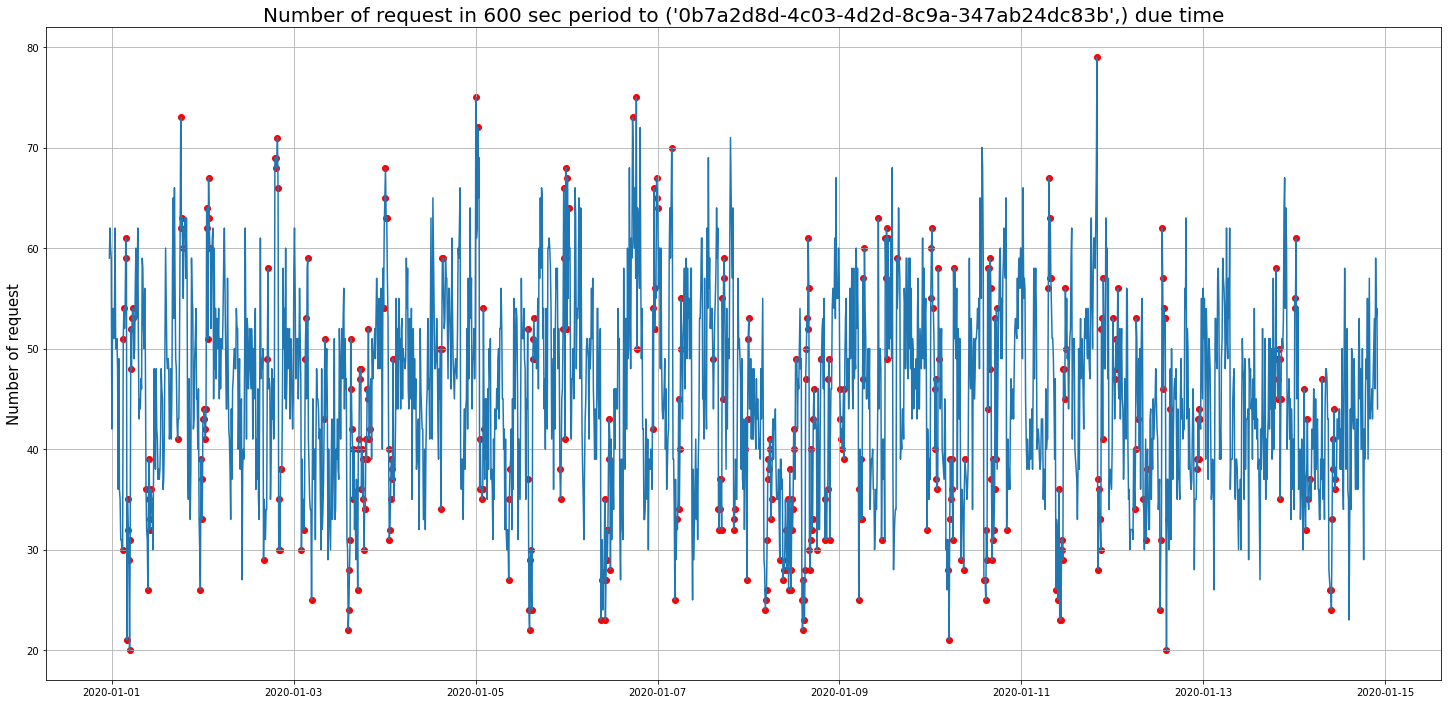

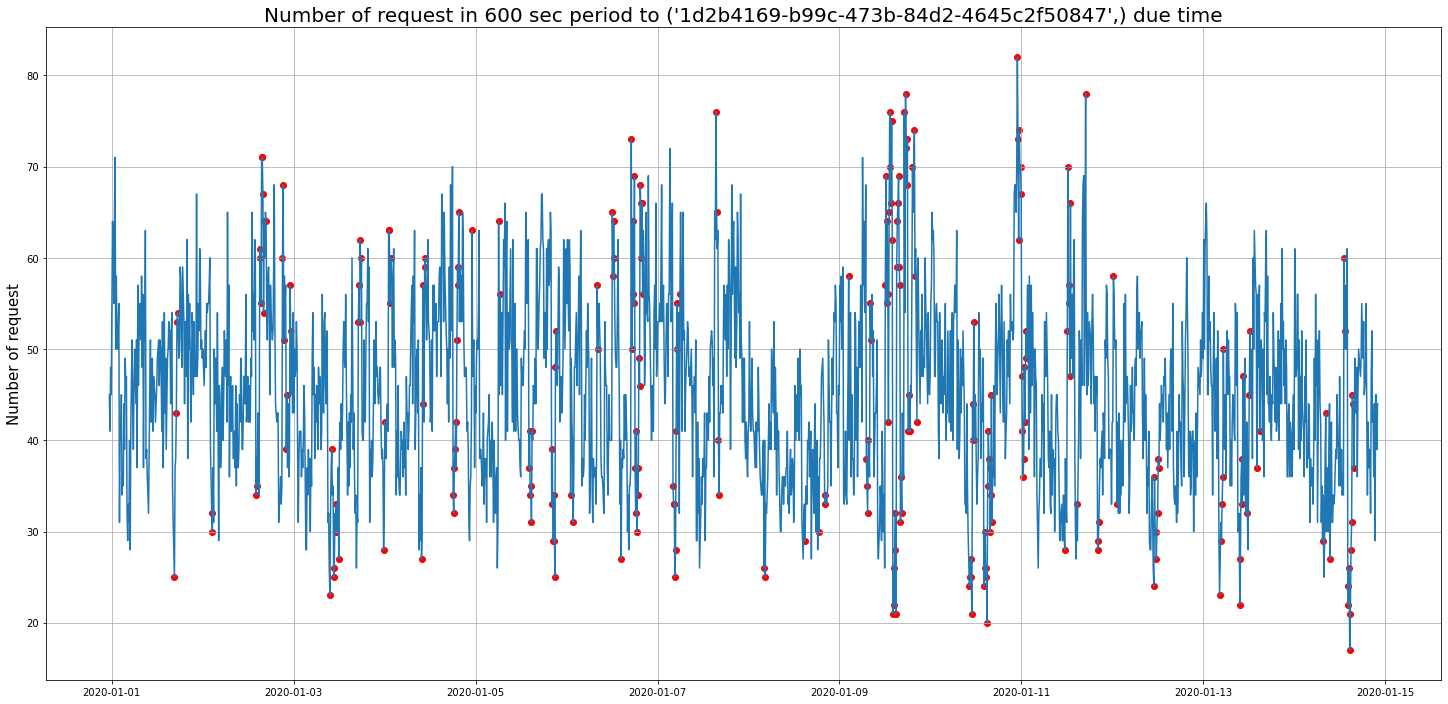

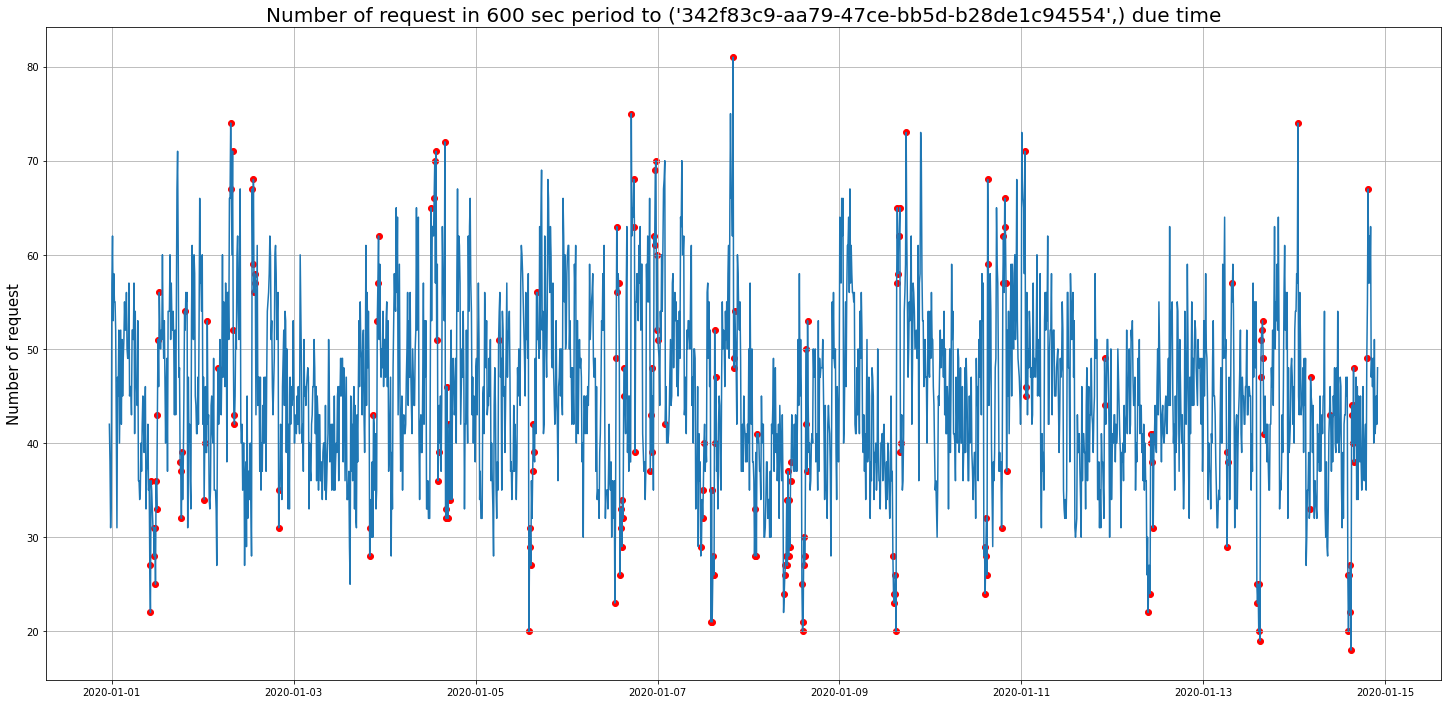

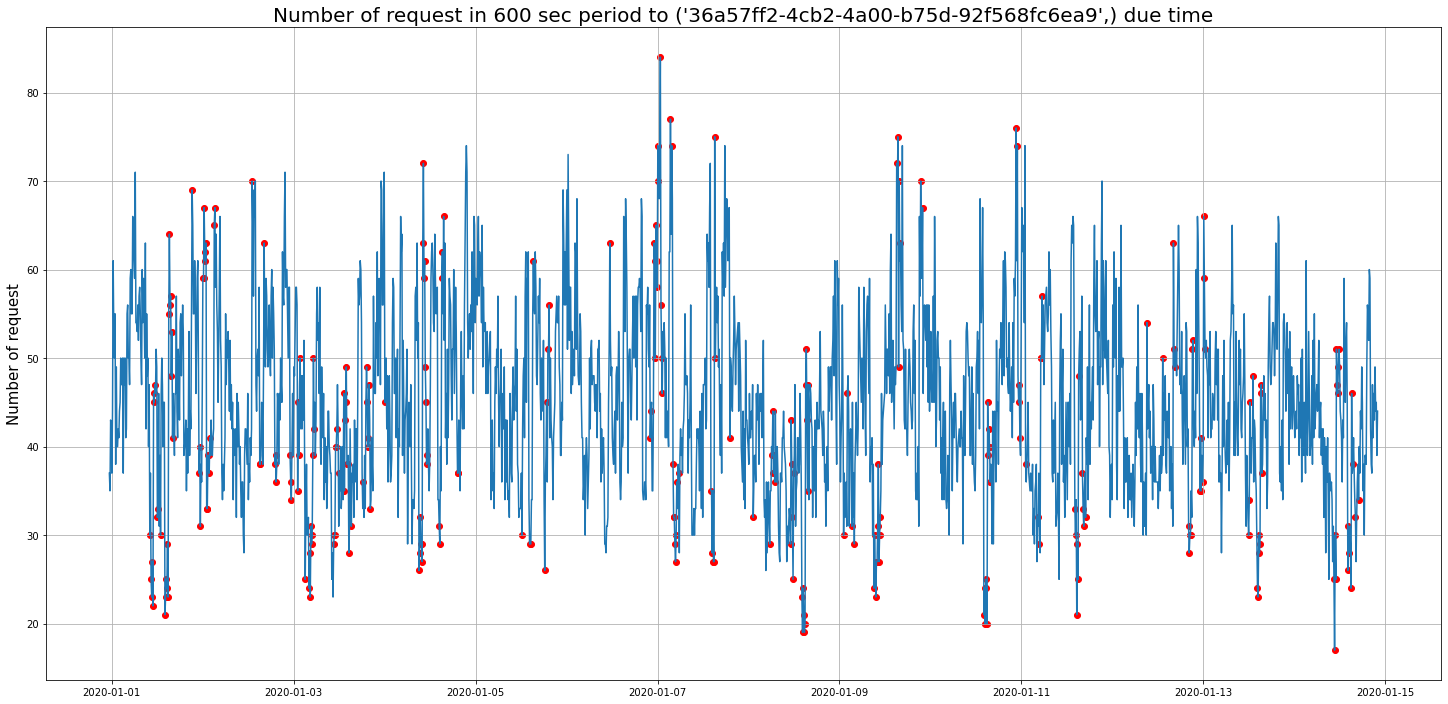

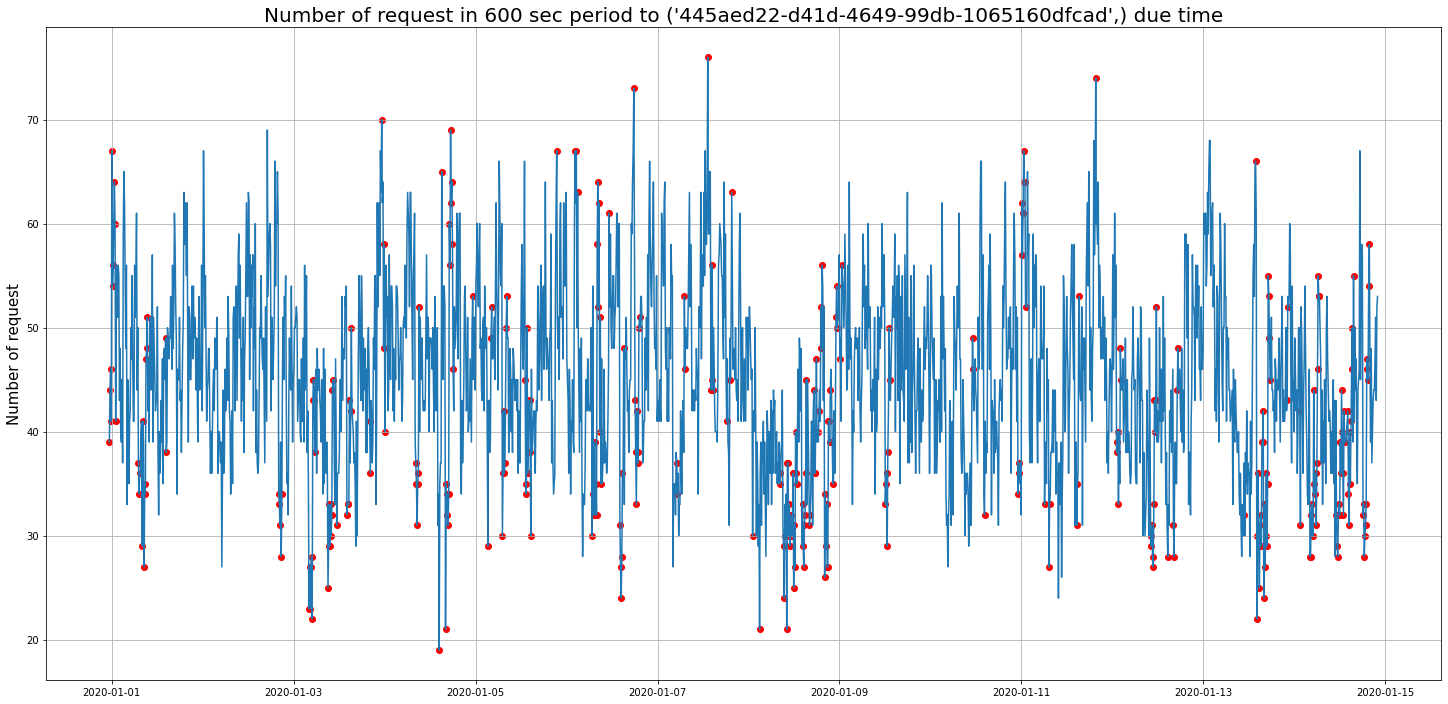

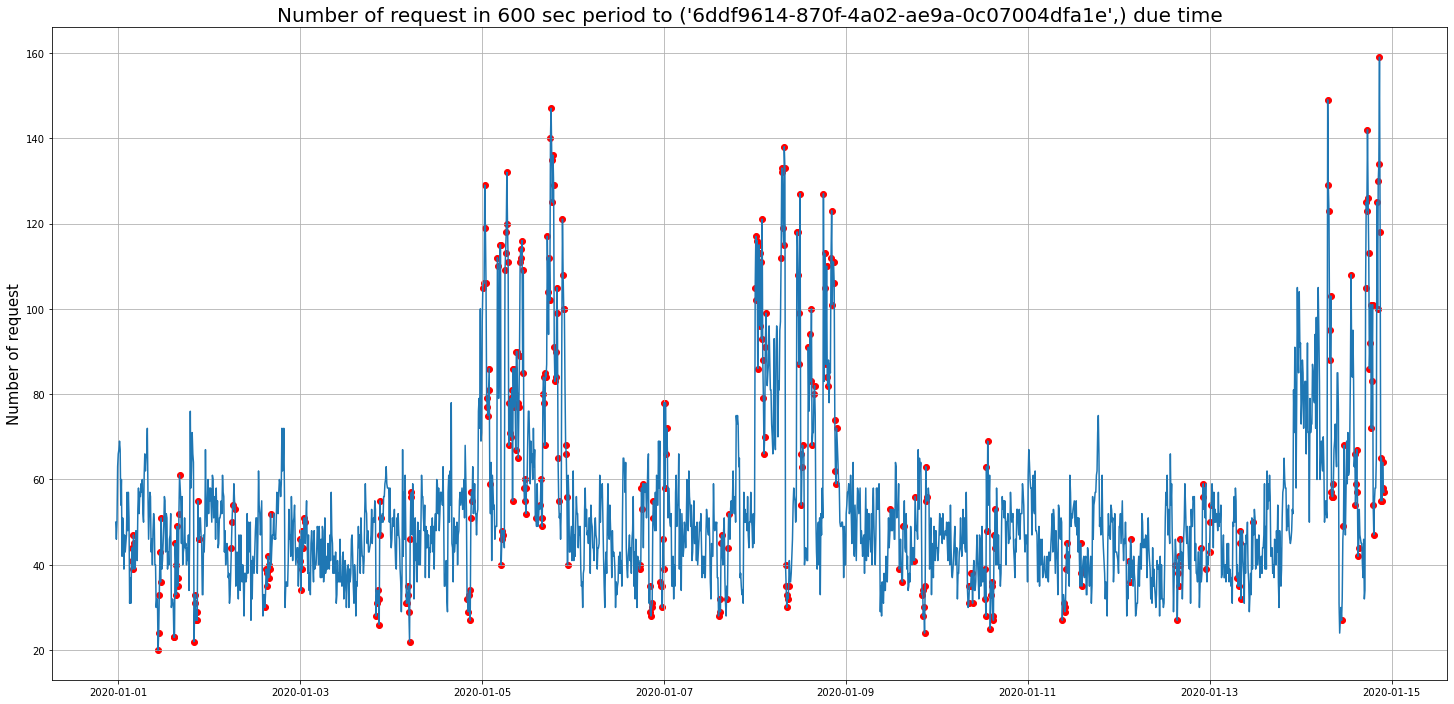

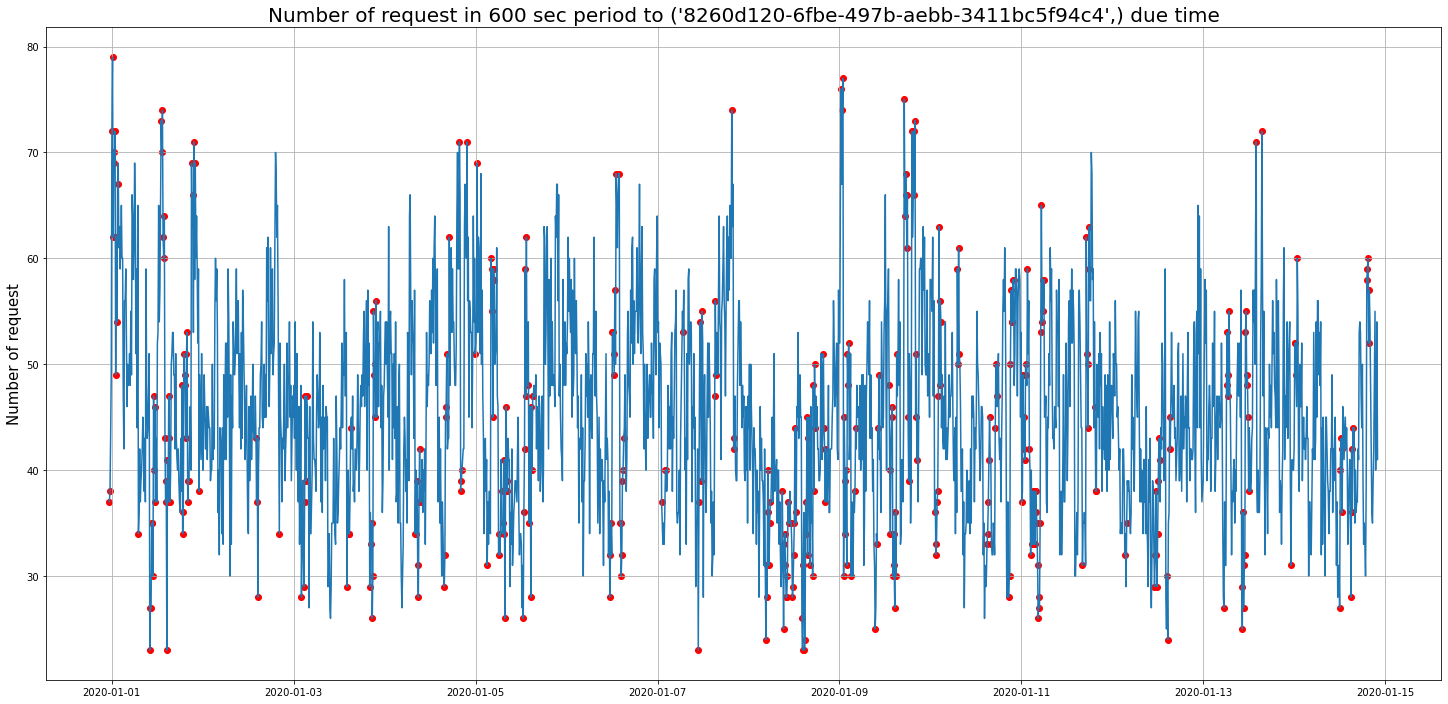

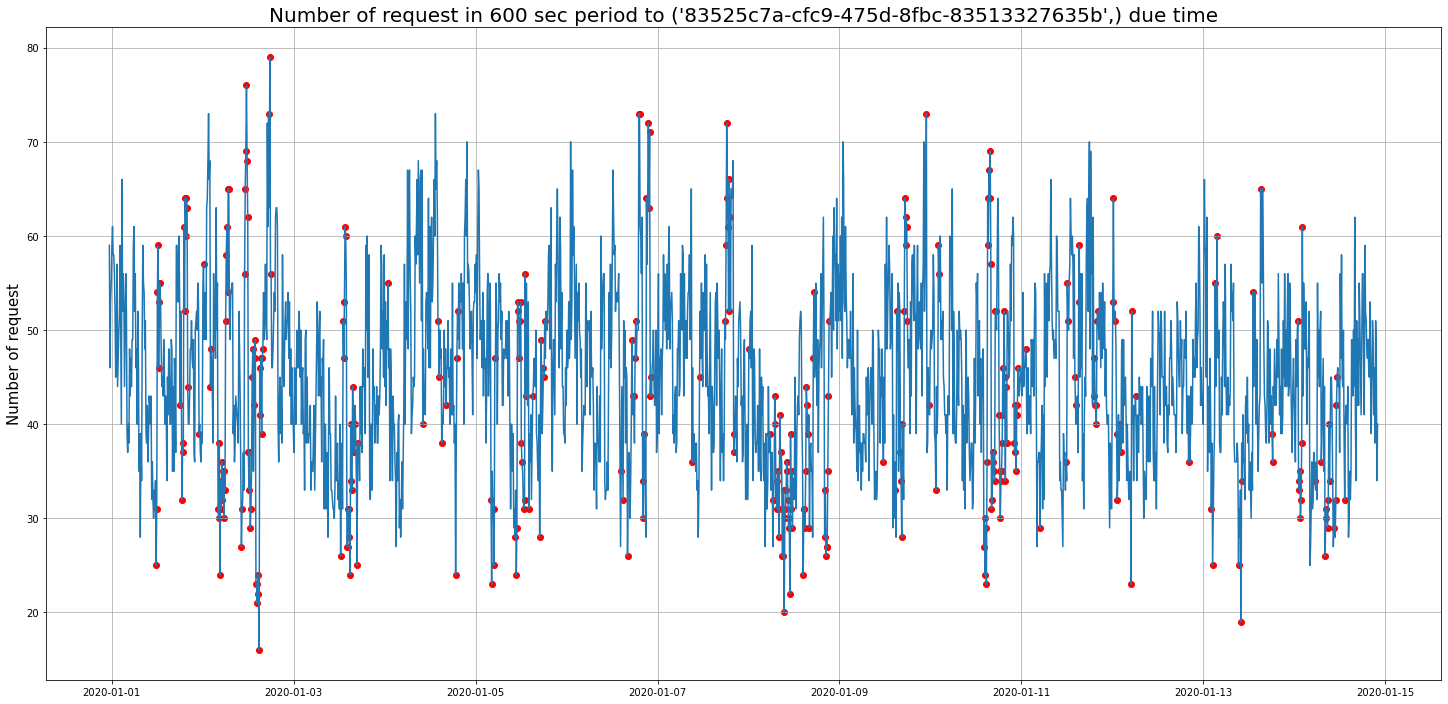

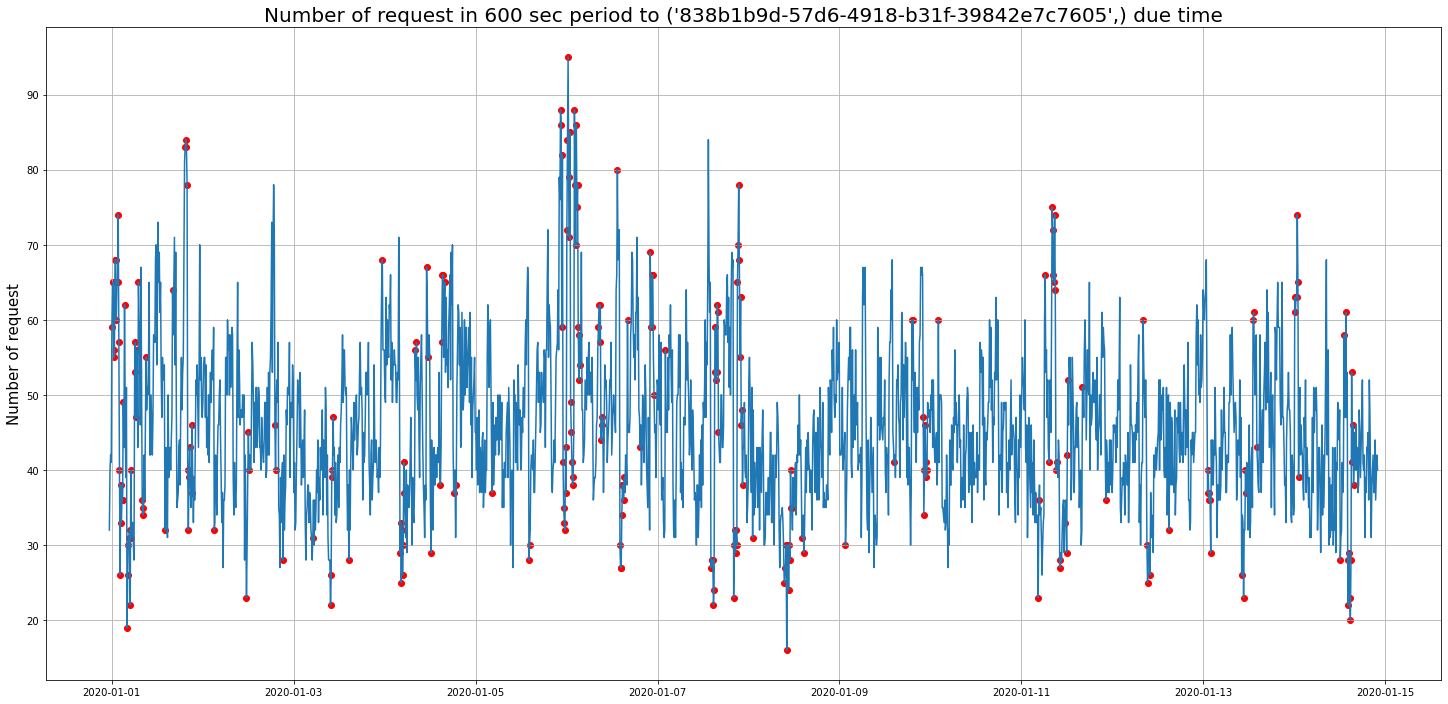

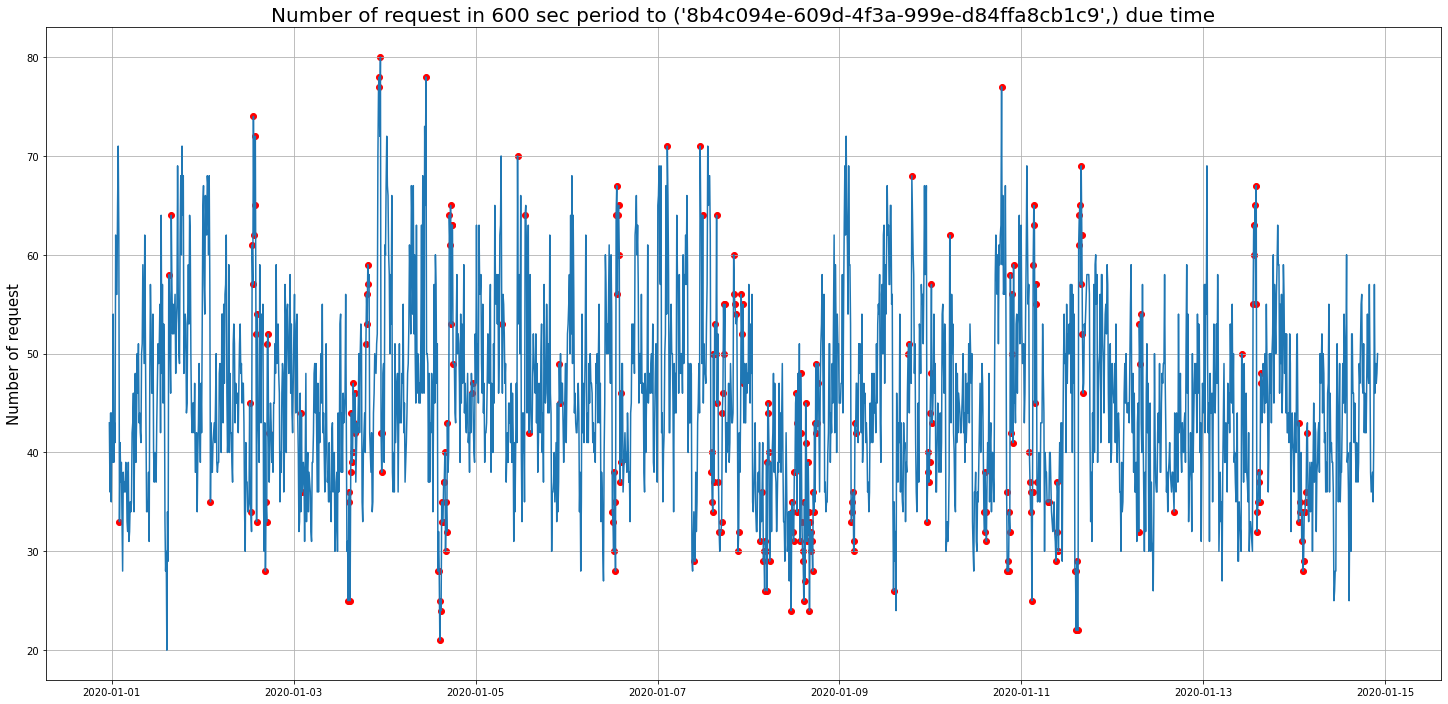

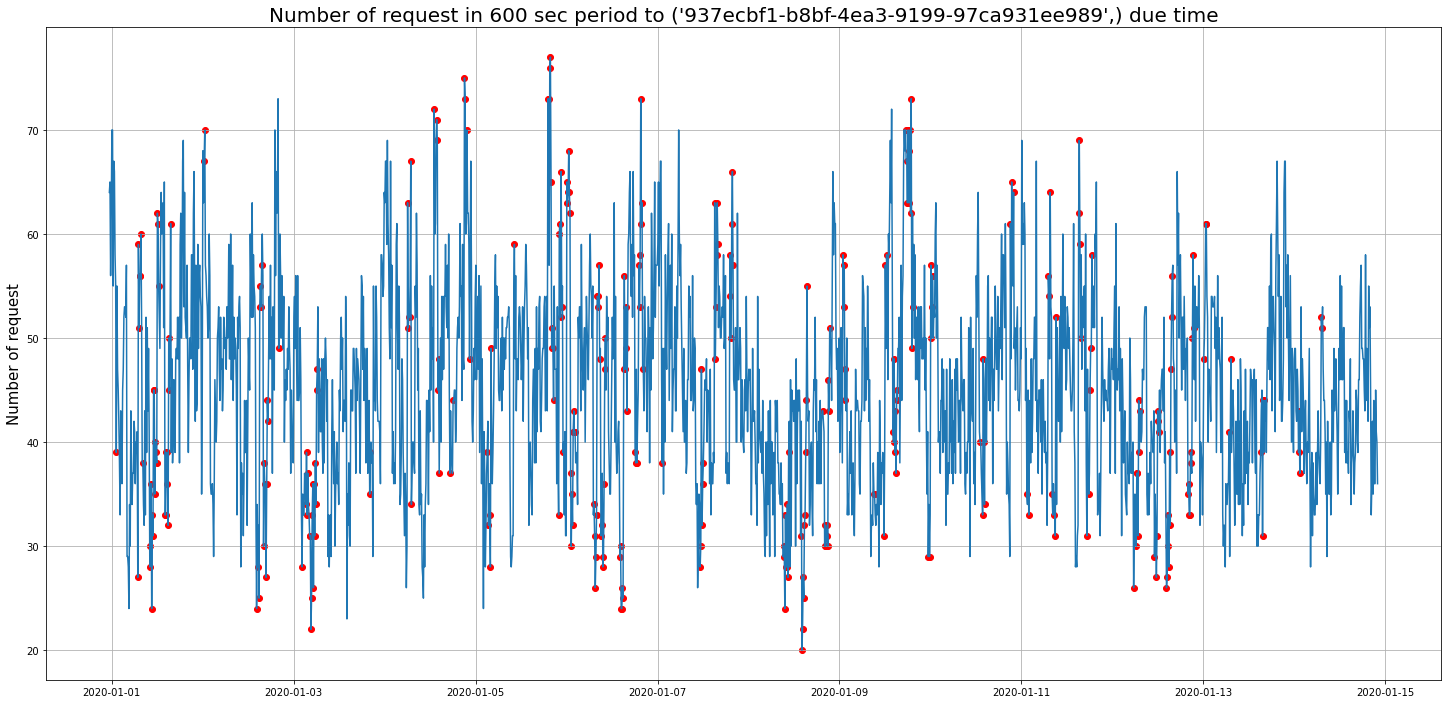

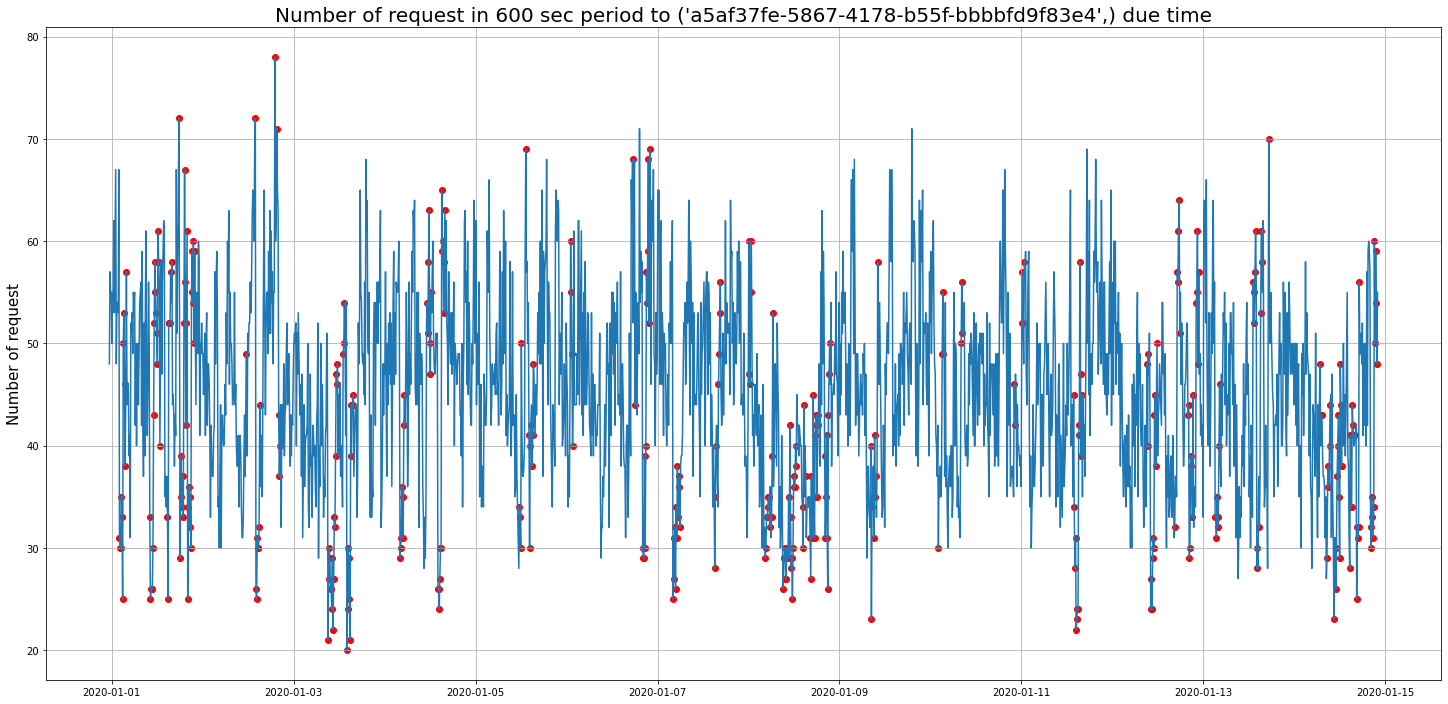

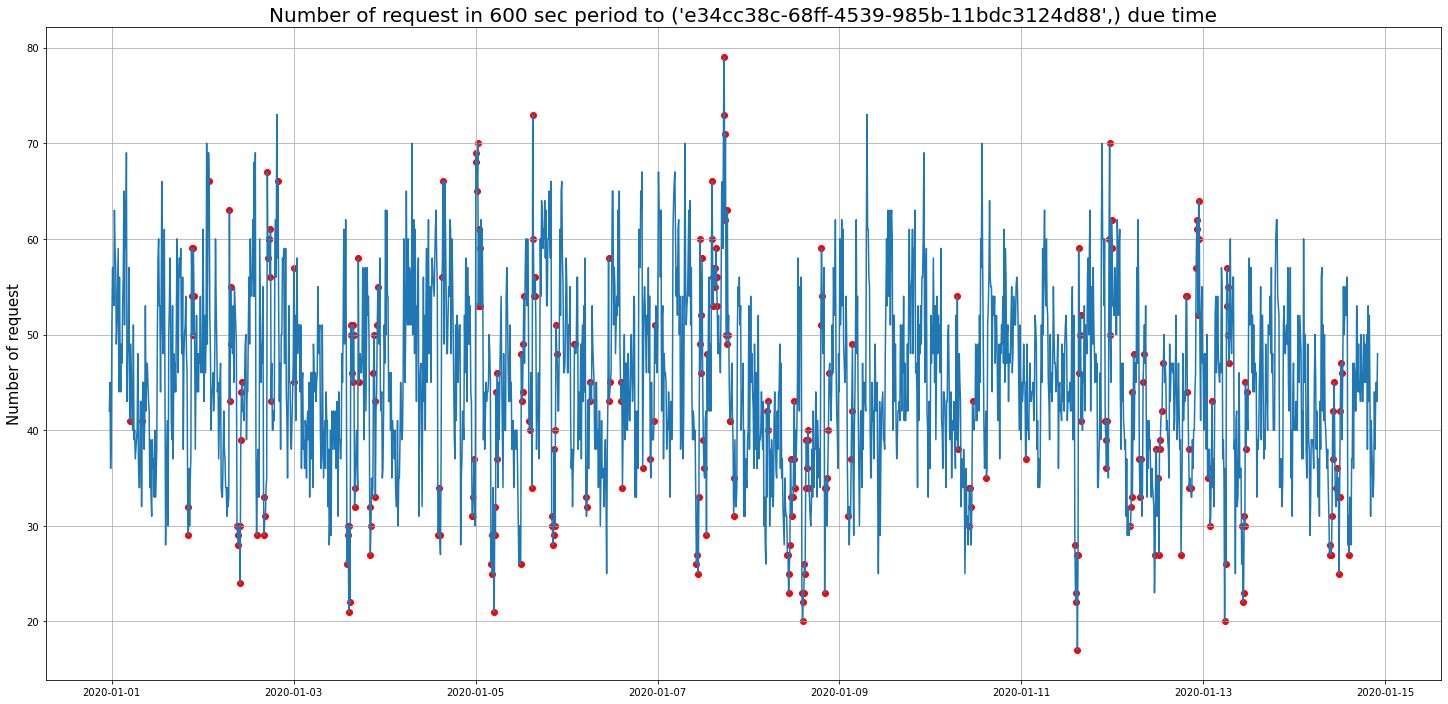

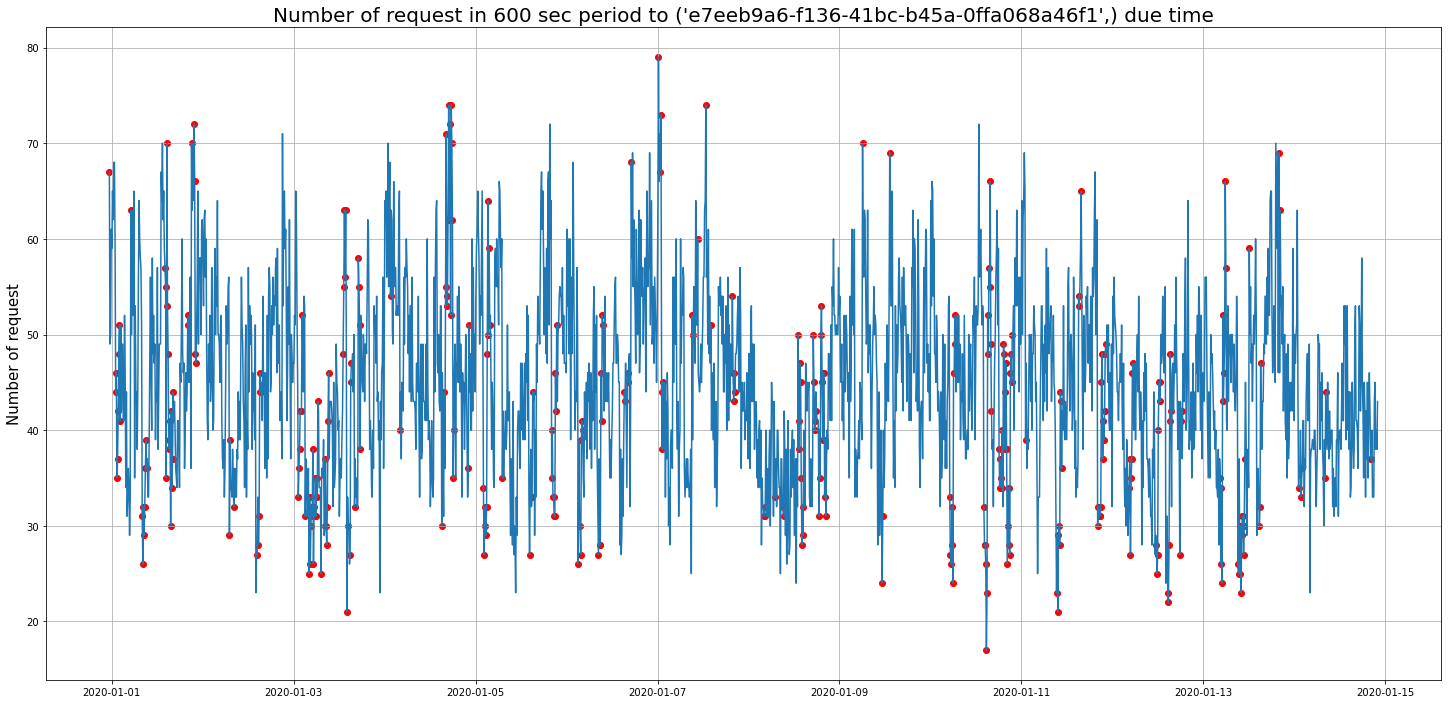

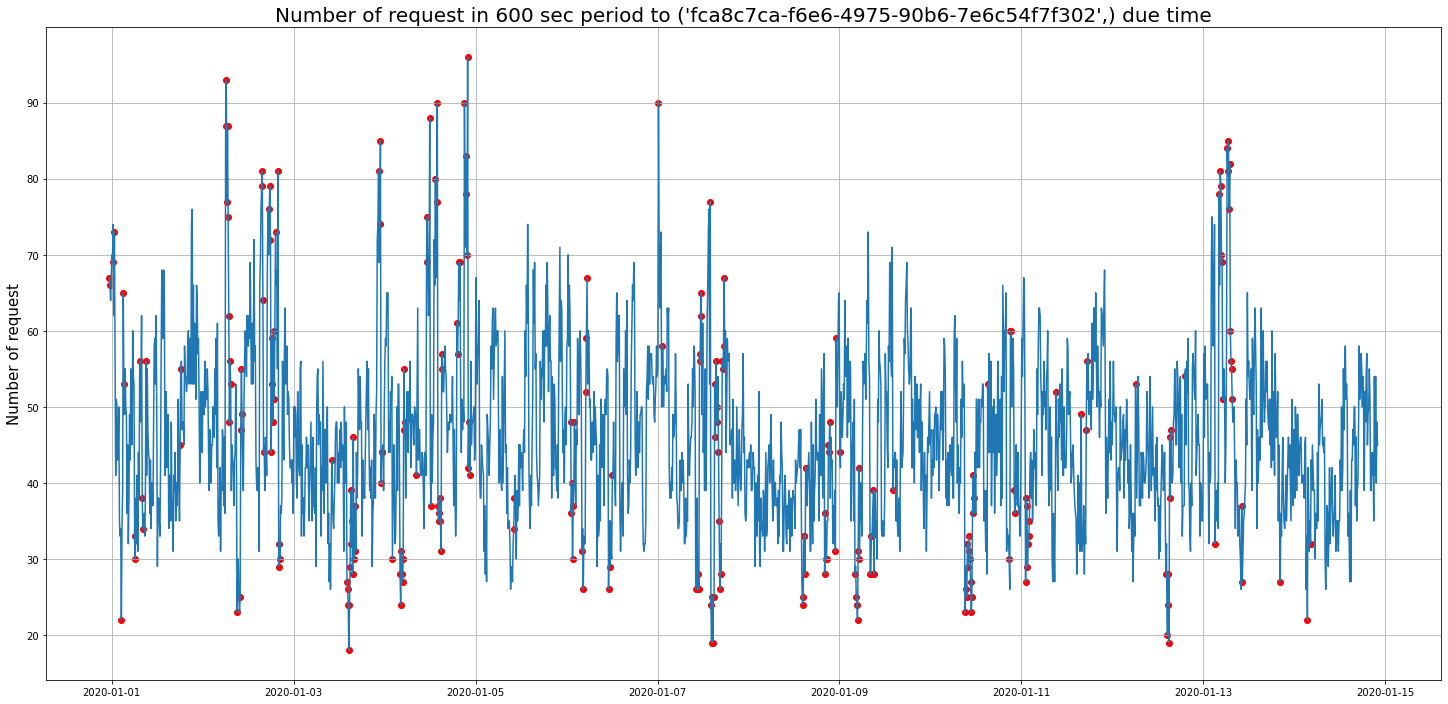

In [5]:
import matplotlib.pyplot as plt

for anomaly_pred_df in anomaly_pred_dfs:
    anomaly_pred_df.sort_index(inplace=True)
    anomaly_pred_df['time'] = pd.to_datetime(anomaly_pred_df.index, unit='s')
    only_anomalies = anomaly_pred_df[anomaly_pred_df.anomaly_flag==-1]

    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(anomaly_pred_df.time, anomaly_pred_df.User_size)
    plt.scatter(only_anomalies.time, only_anomalies.User_size, color='red')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Number of request in {period} sec period to {tuple(anomaly_pred_df[dimensions].values[0])} due time', fontsize=20)
    plt.show()